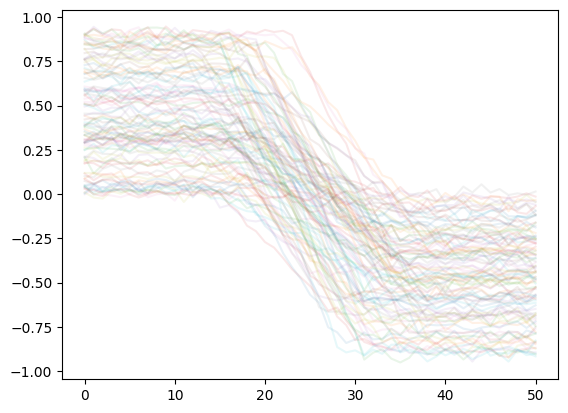

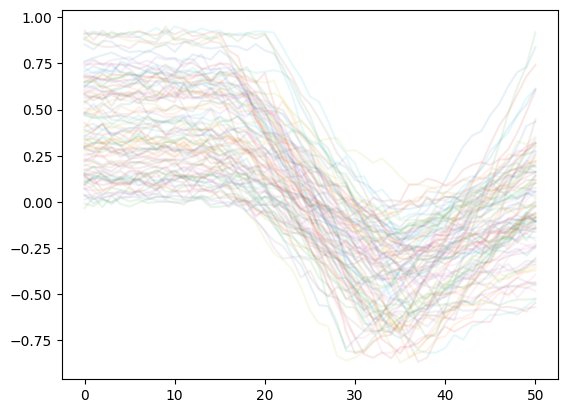

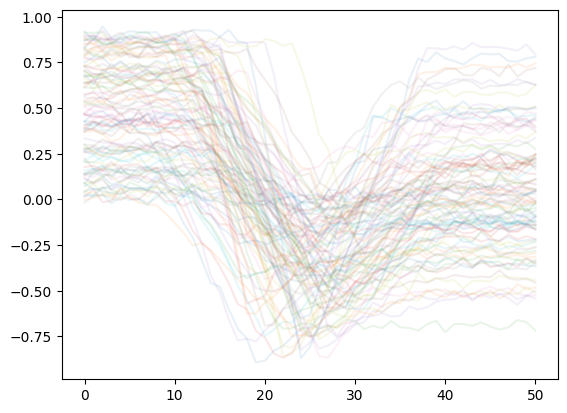

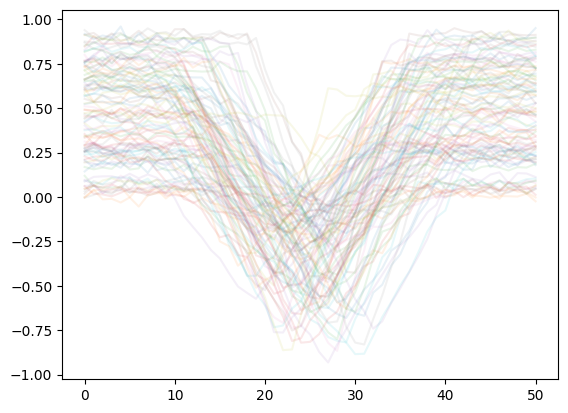

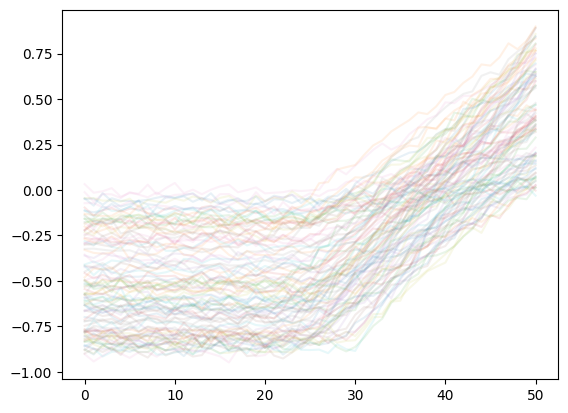

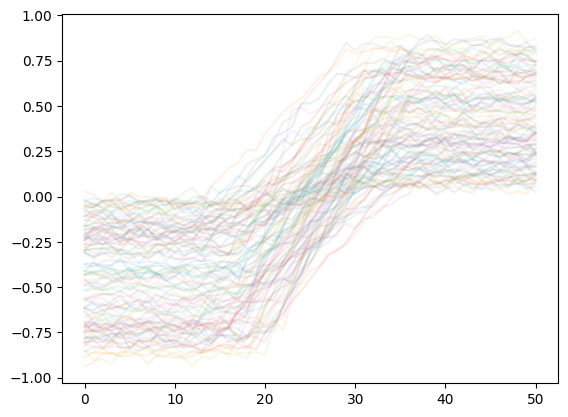

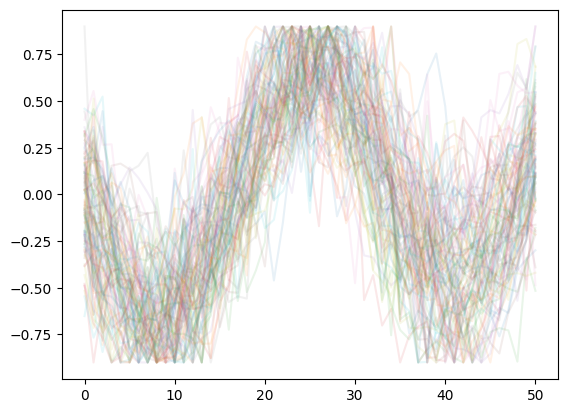

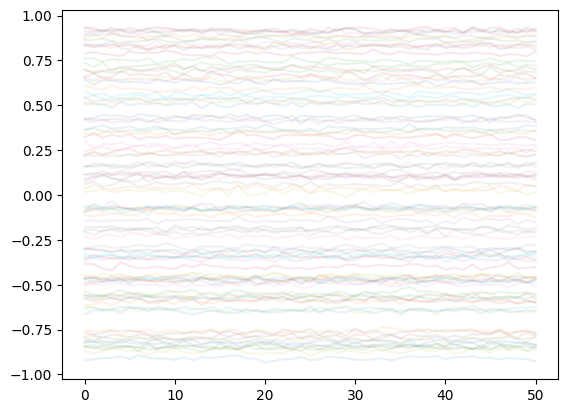

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/datasets.csv")

# 获取标签的唯一值
labels = df['label'].unique()

# 遍历每个标签
for label in labels:
    # 创建一个新的图形

    plt.figure()

    # 获取该标签的所有数据
    data = df[df['label'] == label]['dataset']

    # 将数据转换为列表
    data_list = [eval(i) for i in data]

    # 绘制数据
    for data in data_list:
        plt.plot(data,alpha=.1)

# 显示图形
plt.show()

# 保存图像
# plt.savefig(f'plot_{label}.png')

## 应用分类器

In [ ]:
!pip install pyts

In [ ]:
!pip install pickle-mixin

In [ ]:
!pip install sktime

- *Bossvs&TimeSeriesForest Classifier*

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from pyts.classification import BOSSVS
from pyts.classification import TimeSeriesForest
from sktime.classification.deep_learning import CNNClassifier
from sklearn.metrics import accuracy_score
import pickle
import time

df = pd.read_csv('/content/datasets.csv')
df['dataset'] = df['dataset'].apply(lambda x: np.array(eval(x)))

# 将DataFrame转换为numpy数组
data = df['dataset'].values
labels = df['label'].values

# 将数据集转换为二维数组
data = np.array([np.array(x) for x in data])

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 创建BOSSVS分类器
boss_clf = BOSSVS(window_size=28)

# 训练模型
st = time.time()
boss_clf.fit(X_train, y_train)

# 评估模型
boss_clf_score = boss_clf.score(X_test, y_test)
et = time.time()
print('cosuming time:',et-st)
print('bossvs classifier score:', boss_clf_score)

# 保存模型
with open('/content/bossvs_model.pkl', 'wb') as f:
    pickle.dump(boss_clf, f)

# 创建TimeSeriesForest分类器
tsf_clf = TimeSeriesForest(random_state=43)
st = time.time()
tsf_clf.fit(X_train, y_train)
tsf_clf_score = tsf_clf.score(X_test, y_test)
et = time.time()
print('cosuming time:',et-st)
print('TimeSeriesForest classifier Score:', tsf_clf_score)
with open('/content/timeseriesforest_model.pkl', 'wb') as f:
    pickle.dump(tsf_clf, f)

# 创建CNN分类器
cnn_clf = CNNClassifier()
st = time.time()
cnn_clf.fit(X_train,y_train)
y_pred = cnn_clf.predict(X_test)
cnn_clf_score = accuracy_score(y_pred,y_test)
et = time.time()
print('cosuming time:',et-st)
print('cnn classifier score:', cnn_clf_score)
with open('/content/cnn_model.pkl', 'wb') as f:
    pickle.dump(cnn_clf, f)
print('Done')

cosuming time: 2.877634286880493
bossvs classifier score: 0.7928571428571428
cosuming time: 13.570075988769531
TimeSeriesForest classifier Score: 0.9392857142857143


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


18/18 [==============================] - 0s 4ms/step
cosuming time: 503.82036113739014
cnn classifier score: 0.9214285714285714
Done


- *CNN Classifier*


In [ ]:
from sktime.classification.deep_learning import CNNClassifier
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import rasterio
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/datasets.csv')
df['dataset'] = df['dataset'].apply(lambda x: np.array(eval(x)))
# 将DataFrame转换为numpy数组
data = df['dataset'].values
labels = df['label'].values

# 将数据集转换为二维数组
data = np.array([np.array(x) for x in data])

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
# 创建CNN分类器
cnn_clf = CNNClassifier()
st = time.time()
cnn_clf.fit(X_train,y_train)
ypred = cnn_clf.predict(X_test)
cnn_clf_score = accuracy_score(ypred,y_test)
et = time.time()
print('training cosuming time:',et-st)
print('cnn classifier score:', cnn_clf_score)

# 对新的数据进行分类
# Load the .tif image
with rasterio.open("/content/NDVI51years_median.tif") as src:
    image_data = src.read()
    row = image_data.shape[1]
    column = image_data.shape[2]
    # Reshape to (rows, columns, bands)
    image_data = np.transpose(image_data, (1, 2, 0))

print('transposed shape:', image_data.shape)

# Reshape the image data to (rows * columns, bands)
X = image_data.reshape(-1, image_data.shape[2])
print('reshaped shape:', X.shape)

# 创建一个MinMaxScaler对象
scaler = MinMaxScaler()

# 对数据进行缩放
X = scaler.fit_transform(X)

# 对新的数据进行分类
st = time.time()
y_pred = cnn_clf.predict(X)
et = time.time()
print('classify cosuming time:',et-st)

result = y_pred.reshape(row,column)
print('classified shape:',result.shape)
print('begin saving classified image....')
# Save the classified image
with rasterio.open('/content/NDVI51years_median_cnn_cls.tif', 'w', driver='GTiff',
                   height=row, width=column, count=1, dtype=rasterio.int8, crs=src.crs, transform=src.transform,
                   nodata=src.nodata, compress='lzw'
                   ) as dst:
    dst.write(result, 1)
print('Done')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


18/18 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


training cosuming time: 314.99869108200073
cnn classifier score: 0.925
transposed shape: (628, 620, 51)
reshaped shape: (389360, 51)
24335/24335 [==============================] - 45s 2ms/step
classify cosuming time: 70.26677584648132
classified shape: (628, 620)
begin saving classified image....
Done


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
